In [30]:
#%pip install mysql.connector
#%pip install seaborn
#%pip install --upgrade mysql-connector-python

In [26]:
# import pandas as pd
# import numpy as np
# import pymysql
# import matplotlib
# import seaborn
# import os


In [ ]:
# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments'),
    ('geolocation.csv', 'geolocation')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = pymysql.connect(
    host='localhost',
    user='root',
    password='123',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/rahul/Data Analysis/Data_Python_Practices/python_sql_project'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector


db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "1234",
                            database = "ecommerce")

cur = db.cursor()

### List all unique cities where customers are located.

In [2]:
query = """ Select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


### Count the number of orders placed in 2017.

In [3]:
query = """Select count(order_id) from orders 
	        where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total order placed in 2017", data[0][0]

('total order placed in 2017', 45101)

### Find the total sales per category.

In [4]:
query = """ Select upper(products.product_category) category, round(sum(payments.payment_value)) sales
from products join order_items
on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id
group by category"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,506739.0
1,FURNITURE DECORATION,1430176.0
2,TELEPHONY,486882.0
3,FASHION BAGS AND ACCESSORIES,218158.0
4,BED TABLE BATH,1712554.0
...,...,...
69,CDS MUSIC DVDS,1199.0
70,LA CUISINE,2914.0
71,FASHION CHILDREN'S CLOTHING,786.0
72,PC GAMER,2174.0


### Calculate the percentage of orders that were paid in installments.

In [5]:
query = """ Select (sum(case when payment_installments >= 1 then 1 else 0 end ))/count(*)*100 
from payments """

cur.execute(query)

data = cur.fetchall()

"The percentage of orders that were paid in installments", data

('The percentage of orders that were paid in installments',
 [(Decimal('99.9981'),)])

### Count the number of customers from each state.

  Coustomer_State  Total Customer
0              SP           41746
1              SC            3637
2              MG           11635
3              PR            5045
4              RJ           12852


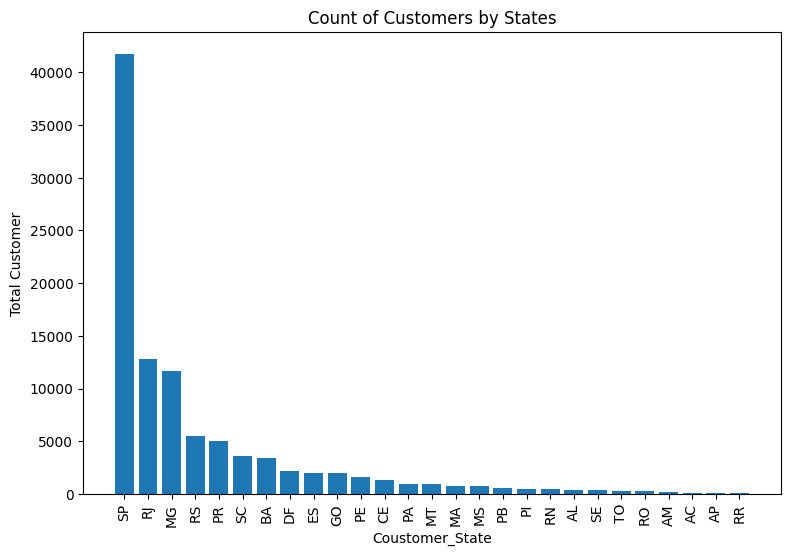

In [6]:
query = """ Select Customer_state, count(customer_id) as Total_customer
from customers
group by customer_state """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["Coustomer_State", "Total Customer"])
print(df.head())
df = df.sort_values(by="Total Customer", ascending=False)

plt.figure(figsize=(9,6))
plt.bar(df["Coustomer_State"], df["Total Customer"])
plt.xticks(rotation=90)
plt.xlabel("Coustomer_State")
plt.ylabel("Total Customer")
plt.title("Count of Customers by States")
plt.show()

### Calculate the number of orders per month in 2018.

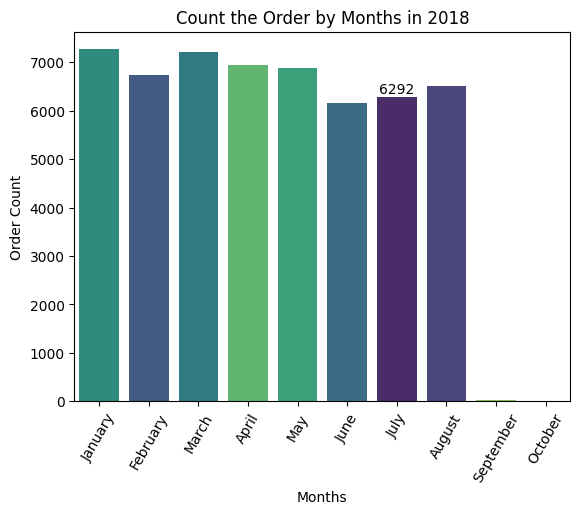

In [7]:
query = """ Select monthname(order_purchase_timestamp) as Months , count(order_id) as Oder_count
from orders where year(order_purchase_timestamp) = 2018
group by Months """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["Months", "Order Count"])
#df.head()
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["Months"], y = df["Order Count"],data = df,order = o, hue= df["Months"], legend=False, palette='viridis')
plt.xticks(rotation=60)

ax.bar_label(ax.containers[0])
plt.title("Count the Order by Months in 2018")

plt.show()

### Find the average number of products per order, grouped by customer city.

In [8]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as count_order
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.count_order),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["Customer City", "Average Products per Orders"])
df.head()

,Customer City,Average Products per Orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00


### Calculate the percentage of total revenue contributed by each product category

In [9]:
query = """ select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) revenue_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by revenue_percentage desc"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=["Category", "Percentage Revenue"])
df.head()

,Category,Percentage Revenue
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


### Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
#import numpy as np

In [12]:
query = """ Select  products.product_category, count(order_items.product_id) as count_product,
round(avg(order_items.price),2) as avegare_price
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "order_count","price"])
df.head()

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])

print("The correlation is", a[0][-1] )

The correlation is -0.10631514167157562


### Calculate the total revenue generated by each seller, and rank them by revenue.

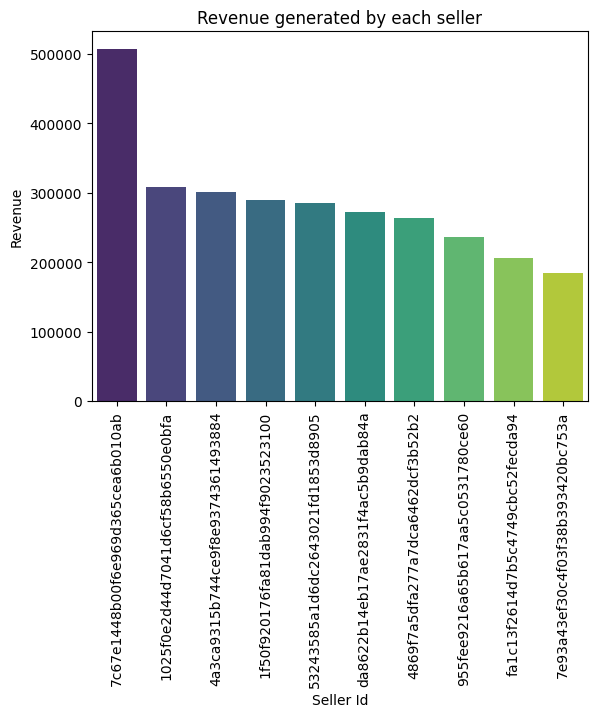

In [13]:
query = """ 
Select *, dense_rank() over(order by revenue desc) ranks from
(Select Order_items.seller_id, sum(payments.payment_value) as revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by Order_items.seller_id) as a; """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=["Seller Id", "Revenue","Rank"])
#df.head()

sns.barplot(x="Seller Id", y="Revenue", data= df.head(10), hue="Seller Id", legend= False, palette='viridis')
plt.xticks(rotation = 90)
#ax.bar_label(ax.containers[0])
plt.title("Revenue generated by each seller")
plt.show()

### Calculate the moving average of order values for each customer over their order history.

In [14]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Customer Id", "Order_purchase_timestamp","Payment","Moving Avg"])
df.head()

,Customer Id,Order_purchase_timestamp,Payment,Moving Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002


### Calculate the cumulative sales per month for each year.

In [15]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Year", " Month", "Payment", "Cumulative Sales"])
df.head()

,Year,Month,Payment,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


### Calculate the year-over-year growth rate of total sales.

In [16]:
query = """
with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 as growth_rate from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


### Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [17]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id"""

cur.execute(query)

data = cur.fetchall()

data

[(None,)]

### Identify the top 3 customers who spent the most money in each year.

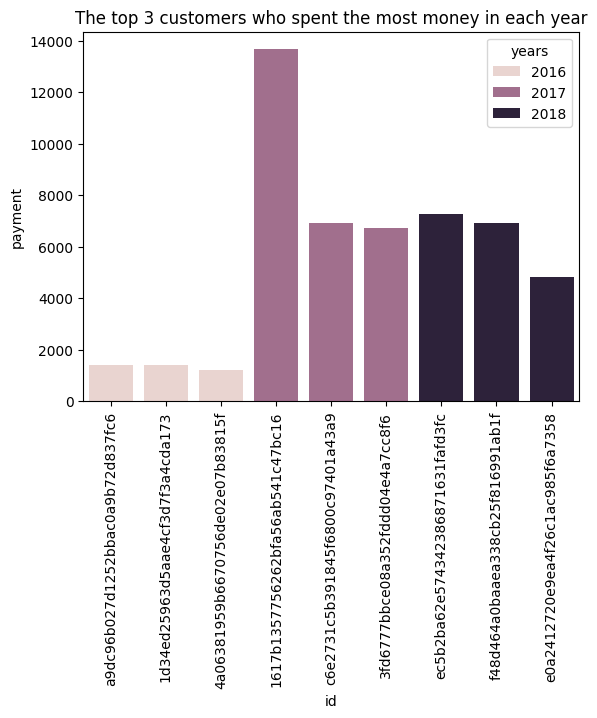

In [18]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.title("The top 3 customers who spent the most money in each year")
plt.xticks(rotation = 90)
plt.show()